# Supernova Host Target Selection

This notebook compares the master list of supernova host targets produced by Maayane Soumagnac and Peter Nugent and published in [DESI-doc-5430](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5430) against DR8 bright and dark targets.

A simple angular separation cut between the SN host RA,Dec and the target catalogs is applied.

In [1]:
from desitarget import io
from desitarget.targetmask import desi_mask, bgs_mask

import os
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table, unique, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

import healpy as hp

mpl.rc('font', size=14)

## SN Host Master List

In [2]:
sntargets = ascii.read('master_host_clean.csv')
sntargets

sn name,index,hemisphere,ra,dec,sn_z,host_ra,host_dec,program,priority
str12,float64,str5,float64,float64,float64,float64,float64,str15,float64
09bce,1.0,north,248.825,55.6331,0.023,248.825666667,55.6344166667,IIps,2.0
09fbf,1.0,north,320.16,1.04803,0.020744,320.159333333,1.04719444444,IIps,4.0
09fbf,2.0,north,320.16,1.04803,0.020744,320.15332,1.052773,IIps,4.0
10aauv,1.0,north,107.855,49.9426,0.023,107.855190525,49.9429865759,IIps,2.0
10bau,1.0,south,139.089,17.7278,0.025958999999999996,139.090375,17.7272222222,IIps,2.0
10bgl,1.0,north,154.77,46.4565,0.03,154.771375,46.4541111111,IIps,2.0
10dvb,1.0,north,259.051,31.7933,0.022941999999999997,259.044333333,31.7923055556,IIps,2.0
10hny,1.0,north,226.105,49.4008,0.026548000000000002,226.102875,49.39875,IIps,2.0
10hny,2.0,north,226.105,49.4008,0.026548000000000002,226.1004,49.40329,IIps,2.0


### Plot SN Host Coordinates

Plot the SN host positions, color-coded by SN program as identified in the master list.

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Anna 8 8
IIps 55 63
RCF 1106 1169
RCF/IIps 10 1179
RCF/RCF 2 1181
SNe_Ia 7429 8610
SNe_Ia/Anna 2 8612
SNe_Ia/IIps 13 8625
SNe_Ia/RCF 2129 10754
SNe_Ia/RCF/Anna 4 10758
SNe_Ia/RCF/IIps 69 10827


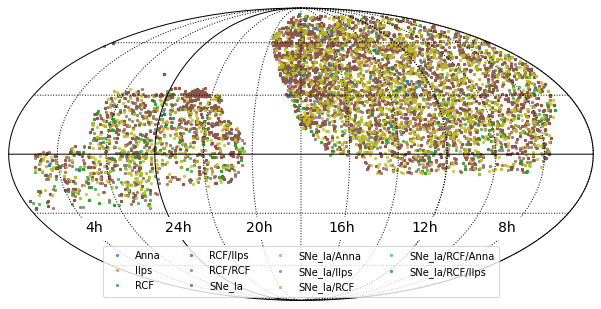

In [3]:
nside = 4
npix = hp.nside2npix(nside)
bkg = np.zeros(npix)
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=270, coord='C', title=None, notext=True)
hp.graticule()

progs = np.unique(sntargets['program'])
tot = 0
for prog in progs:
    select = sntargets['program'] == prog
    tot += np.sum(select)
    print(prog, np.sum(select), tot)
    hp.projscatter(sntargets['host_ra'][select], sntargets['host_dec'][select],
                   lonlat=True, marker='o', s=5, alpha=0.7,
                   label=prog);

for _ra in [0,60,120,180,240,300,359]:
    hp.projtext(_ra, -40, '{:d}h'.format(int(np.round(_ra/15))),
                horizontalalignment='center', backgroundcolor='w', lonlat=True)

plt.legend(ncol=4, fontsize=10, loc=8);

## DR8 Sweep Files

Access Legacy Survey objects in the DR8 sweep files. Then compare their positions to the master list. Any object within a small distance (e.g., 1") of an object in the master list will be kept.

In [4]:
def get_sweepfiles(sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0', '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']):
    """Given a search folder or folders, return a list of sweep files.
    
    For details on file locations see For details see http://legacysurvey.org/dr8/files/.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    
    Returns
    -------
    sweeplist : list
        List of sweep files.
    """
    sweeplist = None
    
    if np.isscalar(sweepfolders):
        sweeplist = io.list_sweepfiles(sweepfolders)
    else:
        for fldr in sweepfolders:
            if sweeplist is None:
                sweeplist = io.list_sweepfiles(fldr)
            else:
                sweeplist += io.list_sweepfiles(fldr)
                
    return sweeplist

#### Load Matched DR8 Objects

Load DR8 objects which match hosts in the master list, or identify matches using a nearest neighbor search. Note: the search is quite time-consuming when run from scratch.

In [5]:
if os.path.exists('selected_hosts_dr8_north.fits') and os.path.exists('selected_hosts_dr8_south.fits'):
    selected_data_north = Table.read('selected_hosts_dr8_north.fits')
    selected_data_south = Table.read('selected_hosts_dr8_south.fits')
    selected_dr8 = vstack([selected_data_north, selected_data_south])
else:
    # Create an array of SkyCoords to match with coordinates in the sweep files.
    sncoords = SkyCoord(ra=sntargets['host_ra'], dec=sntargets['host_dec'], unit='deg')
    
    for catalog in ['north', 'south']:
        sweepfiles = get_sweepfiles(['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/{}/sweep/8.0'.format(catalog)])

        selected_data = None
        colnames=['BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
              'FLUX_G', 'FLUX_R', 'FLUX_Z',
              'NOBS_G', 'NOBS_R', 'NOBS_Z',
              'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
              'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
              'PMRA', 'PMDEC', 'MASKBITS', 'REF_EPOCH']

        for i, sf in enumerate(sweepfiles):
            data = Table(io.read_tractor(sf, columns=colnames))

            datacoords = SkyCoord(ra=data['RA'], dec=data['DEC'], unit='deg')

            # Compute nearest-neighbor distances.
            idx, sep2d, dist3d = match_coordinates_sky(datacoords, sncoords)

            # Select all close targets and append them to a table.
            select = sep2d < 1*u.arcsec

            if selected_data is None:
                selected_data = data[select]
            else:
                selected_data = np.hstack([selected_data, data[select]])
                
            print('{:3d} / {:3d} - {:>50s} {}'.format(i+1, n, sf, len(selected_data)))
                
        tab = Table(selected_data, names=colnames)
        tab.write('selected_hosts_dr8_{}.fits'.format(catalog), overwrite=True)

In [6]:
fluxcut = (selected_dr8['FLUX_G']!=0) & (selected_dr8['FLUX_R']!=0) & (selected_dr8['FLUX_Z']!=0)
np.sum(fluxcut)

10481

<ipython-input-7-338481ad82e7>:1: RuntimeWarning: invalid value encountered in log10
  g_dr8, r_dr8, z_dr8 = [22.5 - 2.5*np.log10(selected_dr8[fluxcut]['FLUX_{}'.format(_)]) for _ in 'GRZ']


(array([   7.,   21.,   85.,  247.,  586.,  855., 1029.,  962., 1085.,
        1321., 1479., 1531., 1041.,  172.]),
 array([10.        , 11.07142857, 12.14285714, 13.21428571, 14.28571429,
        15.35714286, 16.42857143, 17.5       , 18.57142857, 19.64285714,
        20.71428571, 21.78571429, 22.85714286, 23.92857143, 25.        ]),
 <a list of 14 Patch objects>)

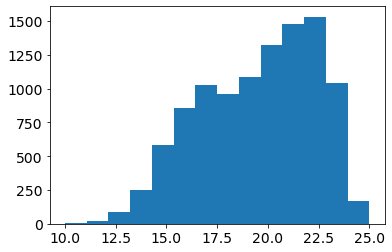

In [7]:
g_dr8, r_dr8, z_dr8 = [22.5 - 2.5*np.log10(selected_dr8[fluxcut]['FLUX_{}'.format(_)]) for _ in 'GRZ']

plt.hist(r_dr8, bins=np.linspace(10,25,15))

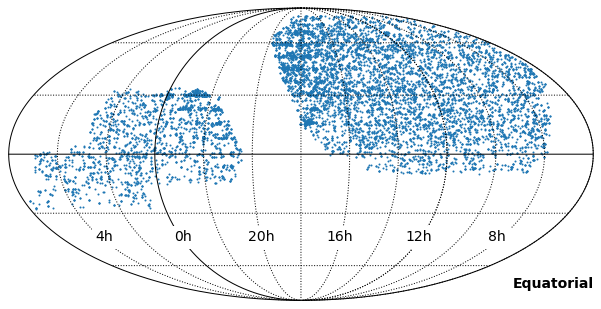

In [8]:
nside = 4
npix = hp.nside2npix(nside)
bkg = np.zeros(npix)

hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=270, coord='C', title='')
hp.graticule(dpar=30, dmer=30)
hp.projscatter(selected_dr8[fluxcut]['RA'], selected_dr8[fluxcut]['DEC'],
               lonlat=True, marker='o', s=1);

for _ra in np.arange(0,360,60):
    hp.projtext(_ra, -45, '{:d}h'.format(_ra//15), horizontalalignment='center', backgroundcolor='w', lonlat=True)

## DR8 Target List

Load the DR8 target lists on NERSC.

Spin through all the DR8 target files (bright and dark time selection) without any object masks applied, and simply look for any target within a small distance (e.g., $1''$) from a SN host.

In [9]:
if os.path.exists('selected_bgsbright_targets_dr8.fits'):
    selected_bgs_targets = Table.read('selected_bgsbright_targets_dr8.fits')
else:
    # Create an array of SkyCoords to match with coordinates in the sweep files.
    sncoords = SkyCoord(ra=sntargets['host_ra'], dec=sntargets['host_dec'], unit='deg')
    
    # Load the DESI DR8 targeting catalogs (bright and dark time).
    dr8_bright = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright'
    dr8_dark = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/dark'
    dr8_files = sorted(glob('{}/*.fits'.format(dr8_bright))) + sorted(glob('{}/*.fits'.format(dr8_dark)))
    
    readcols = ['BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'TARGETID',
                'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
                'FLUX_G', 'FLUX_R', 'FLUX_Z',
                'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
                'MASKBITS', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET']

    selected_targets = None

    # Spin through all DR8 files.
    for dr8_file in dr8_files:
        # Construct an array of target SkyCoords.
        targets = io.read_target_files(dr8_file, columns=readcols)
        targetcoords = SkyCoord(ra=targets['RA'], dec=targets['DEC'], unit='deg')

        # Compute nearest-neighbor distances.
        idx, sep2d, dist3d = match_coordinates_sky(targetcoords, sncoords)

        # Select all targets within 1" of a supernova in the master list and append them to a table.
        select = sep2d < 1*u.arcsec
        if selected_targets is None:
            selected_targets = targets[select]
        else:
            selected_targets = np.hstack([selected_targets, targets[select]])

        # Just for tracking, print the number selected and the cumulative size of the stacked target list.
        print(dr8_file)
        print(np.sum(select), len(selected_targets))
        
    # Keep unique entries.
    selected_targets = unique(Table(selected_targets))
    selected_targets.rename_column('BRICK_OBJID', 'OBJID')
    
    # Pick out BGS targets.
    select_bgs = (selected_targets['BGS_TARGET'] & bgs_mask.mask('BGS_BRIGHT')) != 0
    selected_bgs_targets = selected_targets[select_bgs]
    
    # Write table to a file for use next time the notebook is loaded.
    selected_bgs_targets.write('selected_bgsbright_targets_dr8.fits', overwrite=True)

### Check Unique Targets and Plot Positions

In [10]:
selected_bgs_targets

BRICKID,BRICKNAME,OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,REF_EPOCH,MASKBITS,PMRA,PMDEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
int32,bytes8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int64,int64,int64,int64
176902,0859m277,7141,85.8873235121088,-27.65141778714597,2721.334,4986.8813,7659.696,164.73271,301.8749,463.67053,0.0,4120,0.0,0.0,35185114069605349,1152921504606846976,131074,0
179188,0096m272,477,9.826157453354435,-27.349316372303438,1951.1991,4221.569,8034.398,66.607635,144.11073,274.2684,0.0,4096,0.0,0.0,35185123657777629,1152921504606846976,131074,0
181923,0563m267,2082,56.263890015345275,-26.80597850158724,140.59074,288.99115,506.0617,8.707079,17.897827,31.34146,0.0,0,0.0,0.0,35185135129200674,1152921504606846976,131074,0
183203,0539m265,389,54.023133059892714,-26.607738252692798,156.87325,321.33072,598.3576,29.248997,59.91207,111.56369,0.0,4096,0.0,0.0,35185140497908101,1152921504606846976,131074,0
184338,0101m262,859,10.1935100768372,-26.342530278646585,232.56964,533.8258,982.9318,29.63351,68.018906,125.243004,0.0,4096,0.0,0.0,35185145258443611,1152921504606846976,131074,0
185635,0109m260,6934,10.835087708763526,-25.8838302011346,61.11845,97.244995,143.3383,8.157445,12.979235,19.131283,0.0,0,0.0,0.0,35185150698461974,1152921504606846976,131074,0
186999,0297m257,2143,29.685651619132592,-25.803598335904184,177.15247,321.0106,502.82748,5.214824,9.449566,14.801697,2015.5,0,0.0,0.0,35185156419487839,1152921504606846976,131074,0
187011,0330m257,3738,33.019306846946776,-25.744532379836794,495.76944,1120.36,2011.877,49.94171,112.86032,202.66795,0.0,4096,0.0,0.0,35185156469821082,1152921504606846976,131074,0
188487,0817m255,5994,81.59908099758154,-25.429944091220044,306.39493,659.4095,1198.0547,26.86501,57.817673,105.04662,0.0,4096,0.0,0.0,35185162660616042,1152921504606846976,131074,0


<ipython-input-11-f3cfa8a44cfa>:1: RuntimeWarning: divide by zero encountered in log10
  g_bgs, r_bgs, z_bgs = [22.5 - 2.5*np.log10(selected_bgs_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']


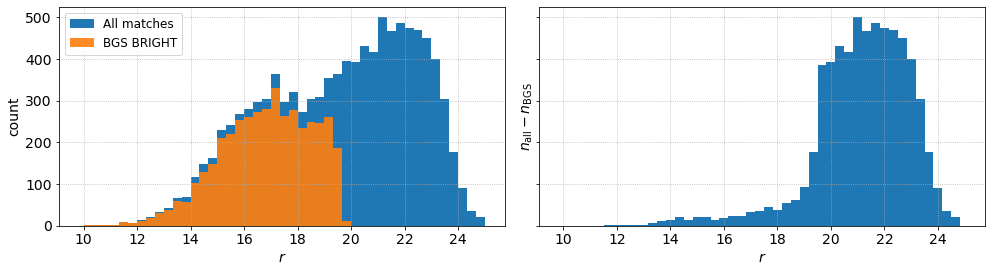

In [11]:
g_bgs, r_bgs, z_bgs = [22.5 - 2.5*np.log10(selected_bgs_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']

fig, axes = plt.subplots(1,2, figsize=(14,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
n_all, bins, patches = ax.hist(r_dr8, bins=np.linspace(10,25,46), label='All matches')
n_bgs, bins, patches = ax.hist(r_bgs, bins=bins, label='BGS BRIGHT', alpha=0.9)
ax.set(xlabel='$r$', ylabel='count')
ax.legend(fontsize=12, loc='upper left')
ax.grid(ls=':')

ax = axes[1]
ax.bar(bins[:-1], n_all-n_bgs, width=np.diff(bins))
len(n_all - n_bgs), bins[:-1], len(np.diff(bins))
ax.set(xlabel='$r$', ylabel='$n_\mathrm{all}-n_\mathrm{BGS}$')
ax.grid(ls=':');

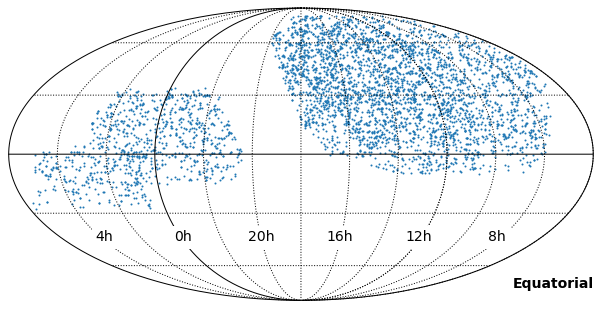

In [12]:
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=270, coord='C', title='')
hp.graticule(dpar=30, dmer=30)
hp.projscatter(selected_bgs_targets['RA'], selected_bgs_targets['DEC'],
               lonlat=True, marker='o', s=1);

for _ra in np.arange(0,360,60):
    hp.projtext(_ra, -45, '{:d}h'.format(_ra//15), horizontalalignment='center', backgroundcolor='w', lonlat=True)

#### Mask Bits of Matching Targets (Non-BGS Bright)

### Grab Legacy Survey Image Cutouts

Just for fun, grab a few target images from the Legacy Survey viewer.

In [13]:
import os
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(_ra, _dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

35185114069605349.jpg exists.
35185123657777629.jpg exists.
35185135129200674.jpg exists.
35185140497908101.jpg exists.
35185145258443611.jpg exists.
35185150698461974.jpg exists.
35185156419487839.jpg exists.
35185156469821082.jpg exists.
35185162660616042.jpg exists.
35185167026886979.jpg exists.
35185167203043954.jpg exists.
35185173263815050.jpg exists.
35185178473137757.jpg exists.
35185179140035295.jpg exists.
35185183581805120.jpg exists.
35185183971873776.jpg exists.


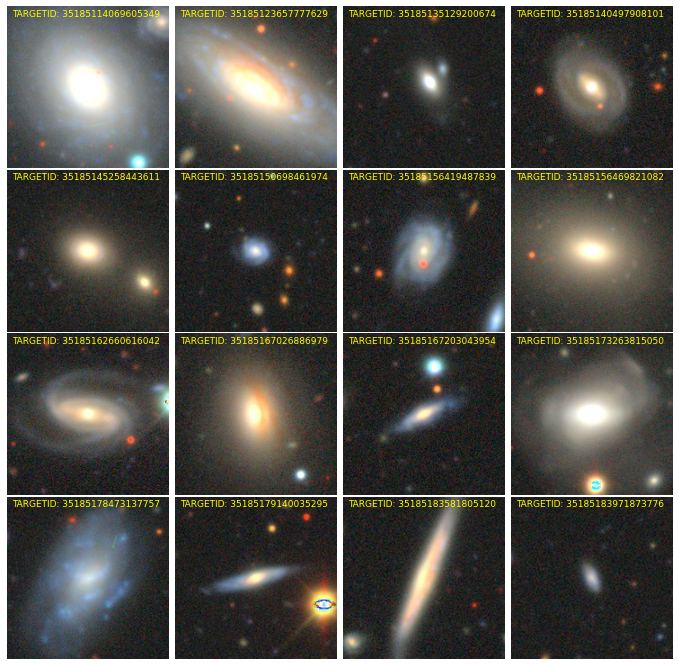

In [14]:
nrow, ncol = 4,4
nimg = nrow*ncol

fig, axes = plt.subplots(nrow, ncol, figsize=(3*nrow, 3*ncol),
                         sharex=True, sharey=True,
                         gridspec_kw={'hspace':0.01, 'wspace':0.01})
axes = axes.flatten()

for i, obj in enumerate(selected_bgs_targets):
    if i >= nimg:
        break
    ax = axes[i]

    _ra  = obj['RA']
    _dec = obj['DEC']
    _id  = obj['TARGETID']
    img_file = get_cutout(_id, _ra, _dec, verbose=True)
    img = mpl.image.imread(img_file)
    
    ax.imshow(img)
    ax.text(5,10, 'TARGETID: {}'.format(_id), color='yellow', fontsize=9)
    ax.axis('off')